In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import plotly.graph_objects as go
from pprint import pprint
from collections import defaultdict
from json import load, dump
import os

/Users/hackinteachk./.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
data = defaultdict(list)
with open("mem_result.txt", "r") as f:
    while f.readable():
        f.readline()
        n = f.readline()
        num = re.match(r"^\[([0-9]{1,2})\]$" ,n).group(1)
        for i in range(4):
            value = np.float(f.readline().strip("\n"))
            data[num].append(value)
        if num == "60":
            break

In [3]:
x = list(map(int, data.keys()))
y = np.array(list(data.values()))

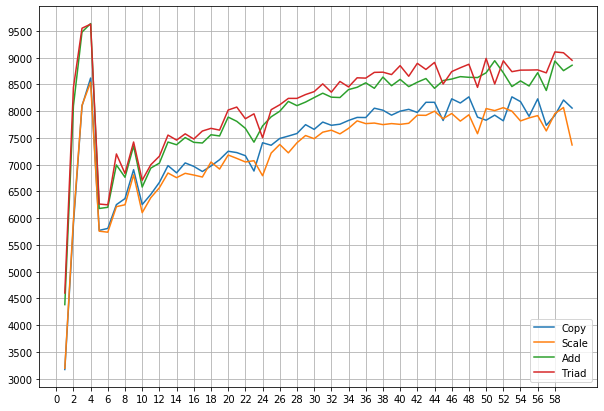

In [4]:
labels=["Copy", "Scale", "Add", "Triad"]
plt.figure(figsize=(10,7))
for i, l in enumerate(labels):
    plt.plot(x,y[:,i], label=l)
plt.legend()
plt.xticks(ticks=np.arange(0, len(data), 2));
plt.yticks(ticks=np.arange(3000, 10_000, 500));
plt.grid()

In [9]:
result_path = "../result/aws"
alg_files = os.listdir(result_path)
alg_res_regex = r"^(.*)-T([\d]{1,2})-R([\d]{1,3}).json$"
# print(alg_files)

data = dict()

for alg in alg_files:
    if ".json" not in alg:
        continue
    di = load(open(os.path.join(result_path, alg), 'r'))
    grps = re.match(alg_res_regex, alg)
    alg_name = grps.group(1)
    thread = int(grps.group(2))
    rounds = grps.group(3)
    
    alg_d = dict()
    if thread not in data:
        data[thread] = dict()

    for k, v in di.items():
        fn, nthr, func = list(map(str.strip, k.split(",")))
        size = 0
        try:
            size = int(re.match(r"^data/map/size-(\d{1,}).csv$", fn).group(1))
        except AttributeError:
            size = int(fn)
        if size not in alg_d:
            alg_d[size] = dict()
        alg_d[size][func] = (v["nanos"]/float(1e9)) + float(v["secs"])
    data[thread][alg_name] = alg_d
# pprint(data)

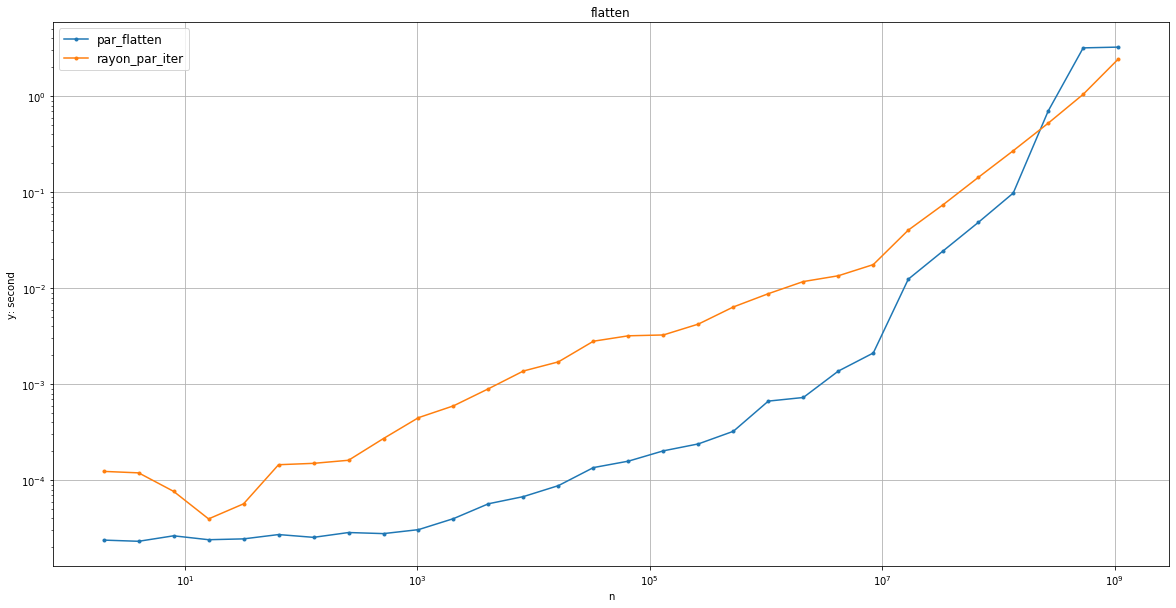

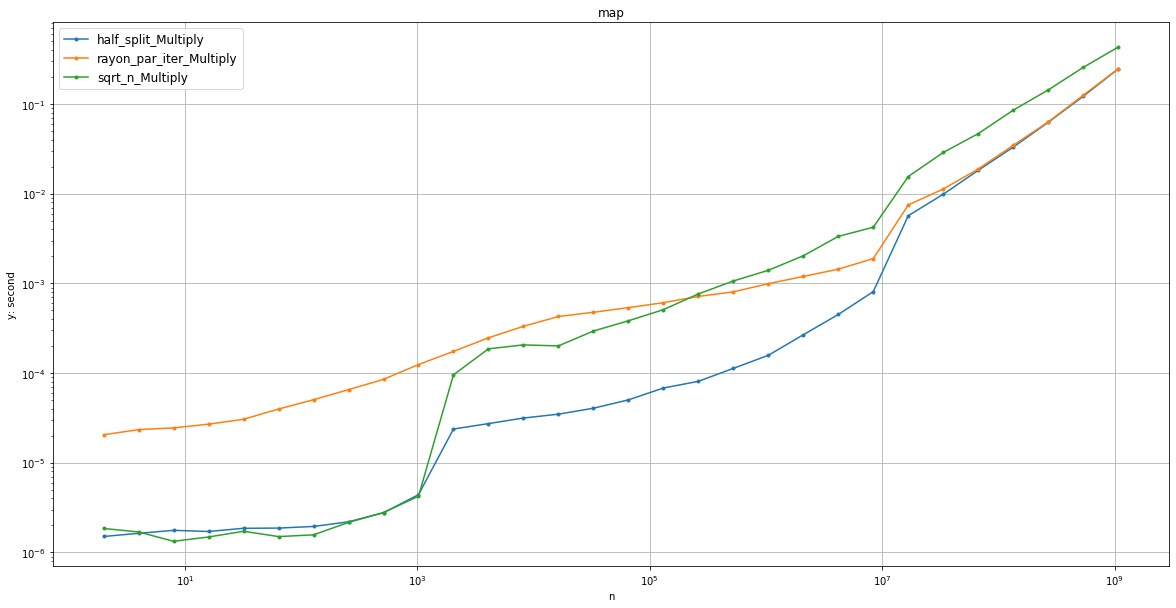

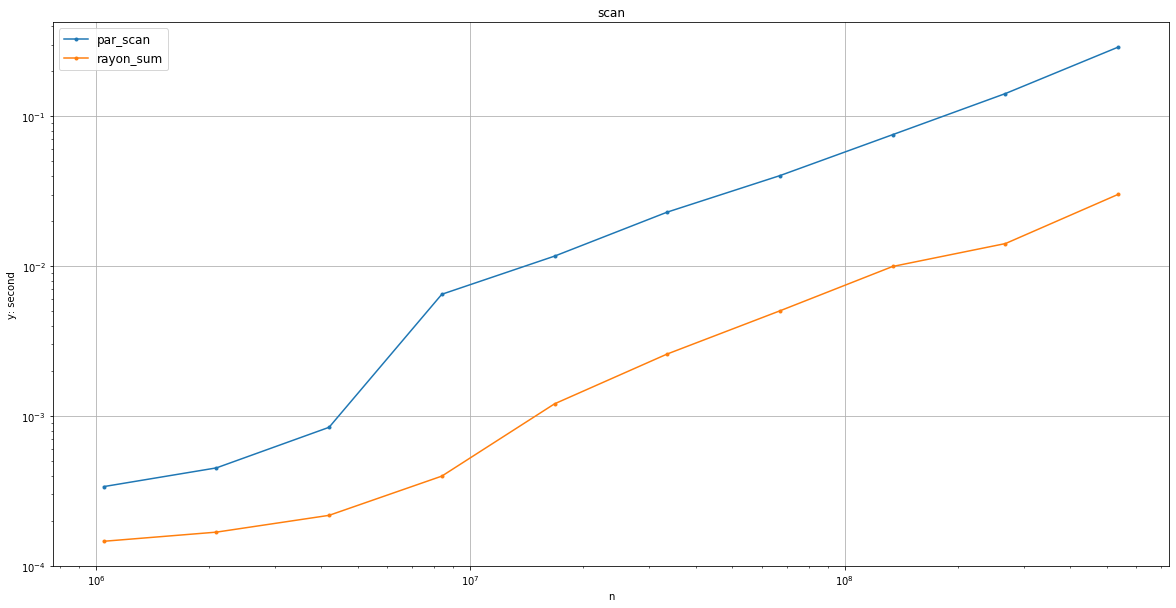

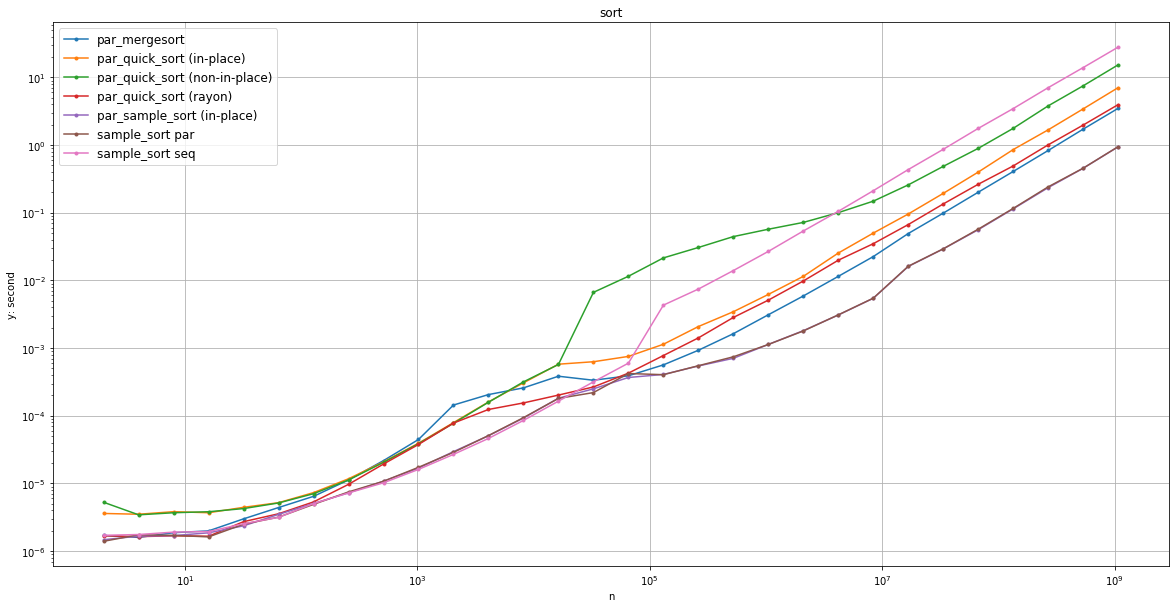

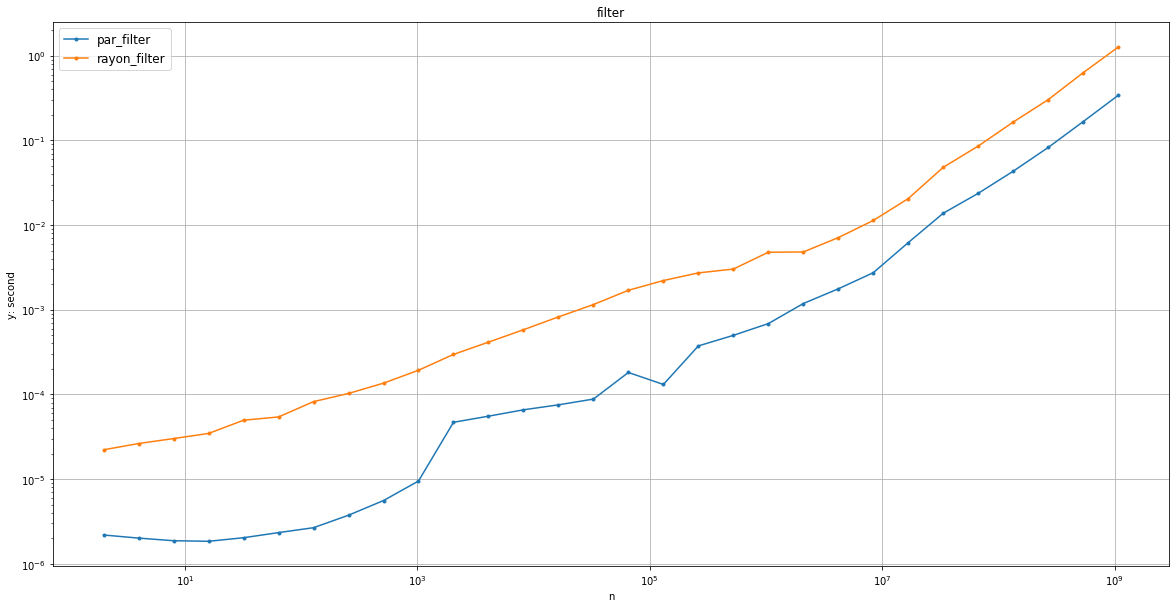

In [10]:
result = dict()

for alg, d in data[36].items():
    result[alg] = dict()
    for size, map_ver in d.items():
        for ver, tm in map_ver.items():
            if ver not in result[alg]:
                result[alg][ver] = {"x":[], "y": [], "xy": []}
            result[alg][ver]["xy"].append((size,tm))
        for ver in map_ver:
            sorted_xy = list(sorted(result[alg][ver]["xy"], key=lambda tup: tup[0]))
            result[alg][ver]["x"] = list(map(lambda x: x[0], sorted_xy))
            y_tmp = list(map(lambda x: x[1], sorted_xy))
            result[alg][ver]["y"] = list(map(lambda x: x[1], sorted_xy))

for alg, vers in result.items():
    plt.figure(figsize=(20,10))
    plt.title(alg)
    plt.xlabel("n")
    plt.ylabel("y: second")
    plt.xscale("log")
    plt.yscale("log")
    for v, pts in vers.items():
#         print(v)
        plt.plot(pts['x'], pts['y'], label=v, marker='.' if alg != "big_map" else "o")
    plt.legend(fontsize="large")
    plt.grid()
    plt.show()

In [67]:
## 3d plot
# result = dict()
# for tn, items in data.items():
#     for alg, d in items.items():
#         if alg not in result:
#             result[alg] = dict()
#         for size, map_ver in d.items():
#             for ver, tm in map_ver.items():
#                 if ver not in result[alg]:
#                     result[alg][ver] = {"x":[], "y": [], "z":[]}
#                 result[alg][ver]["x"].append(size)
#                 result[alg][ver]["y"].append(tm)
#                 result[alg][ver]["z"].append(tn)
# result

In [11]:
result = dict()

for thread, thread_data in data.items():
    for alg, d in thread_data.items():
        for size, map_ver in d.items():
            if size < 1e6: 
                continue
            if size not in result:
                result[size] = dict()
            if alg not in result[size]:
                result[size][alg] = dict()
            for ver, tm in map_ver.items():
                if ver not in result[size][alg]:
                    result[size][alg][ver] = {"x":[], "y": [], "xy": []}
                result[size][alg][ver]["xy"].append((thread, tm))

for size, size_data in result.items():
    for alg, alg_d in size_data.items():
        for ver, ver_d in alg_d.items():
            sorted_xy = sorted(ver_d["xy"], key=lambda tup: tup[0])
            ver_d["x"] = list(map(lambda x: x[0], sorted_xy))
            y_tmp = list(map(lambda x: x[1], sorted_xy))
            ver_d["y"] = list(map(lambda x: y_tmp[0]/x, y_tmp))

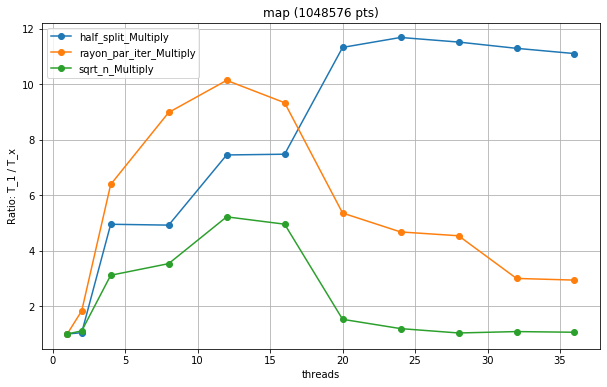

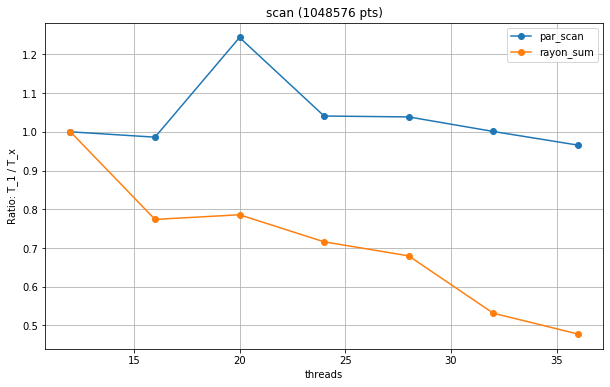

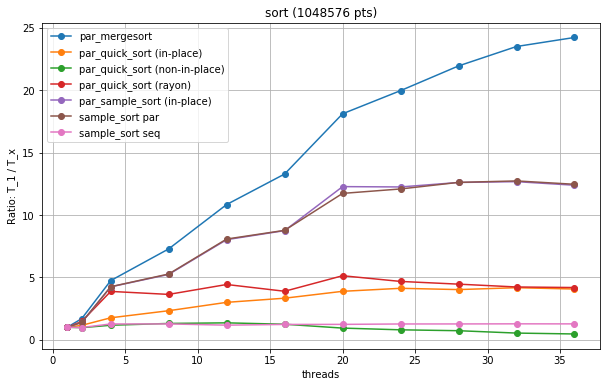

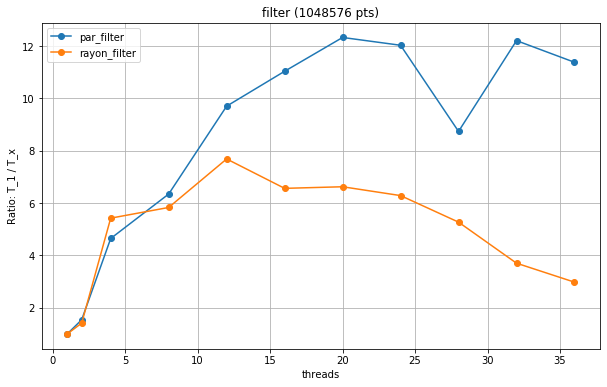

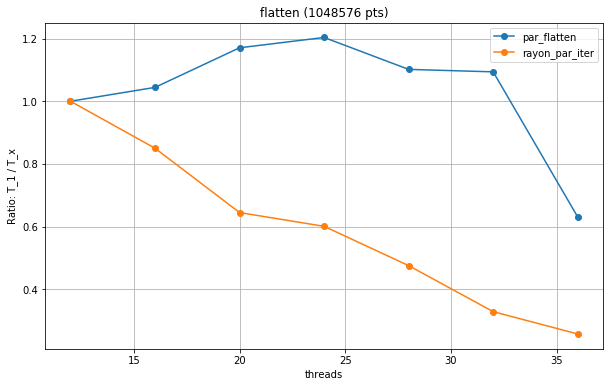

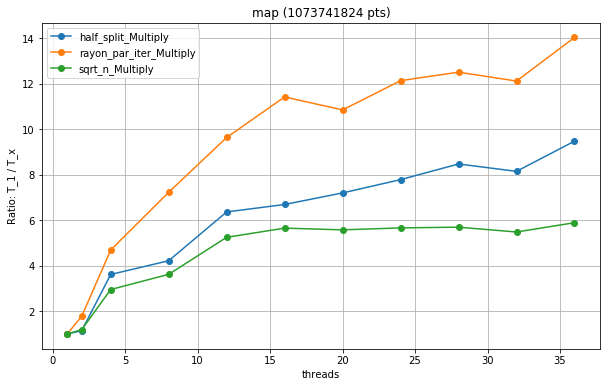

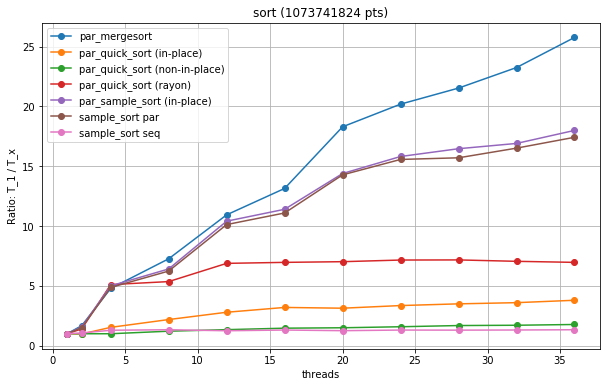

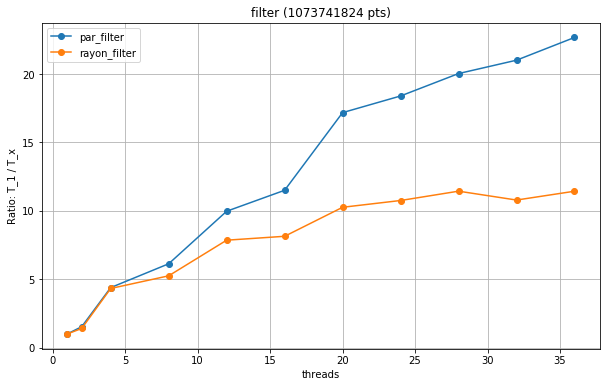

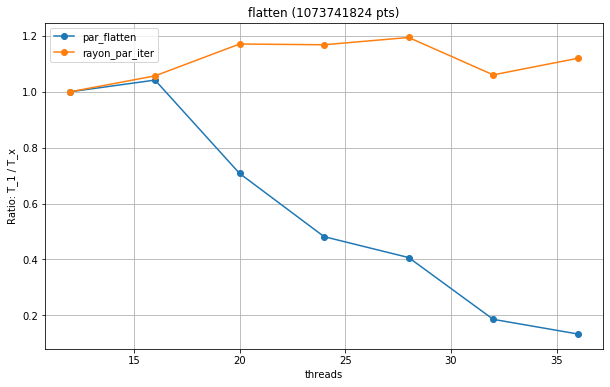

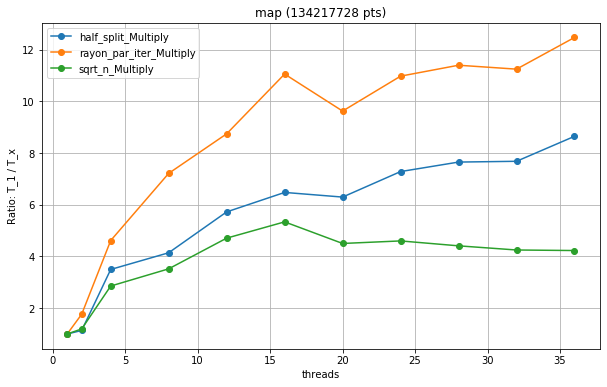

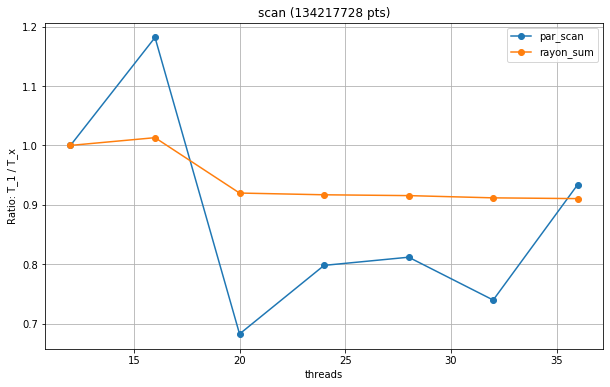

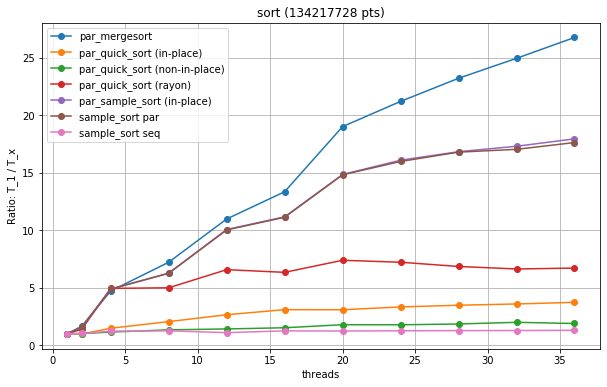

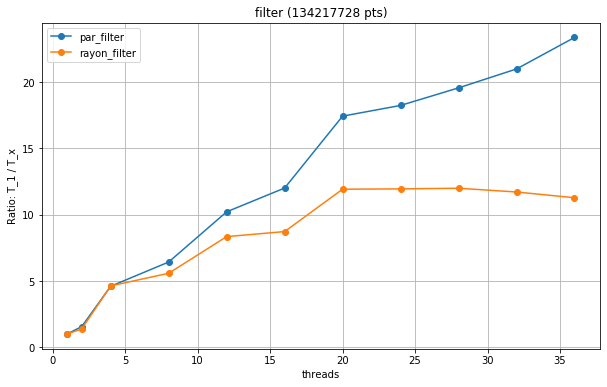

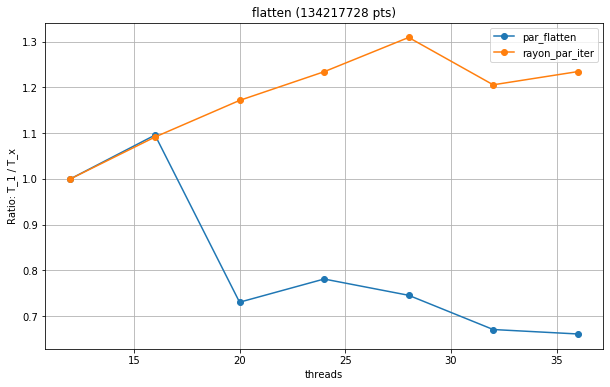

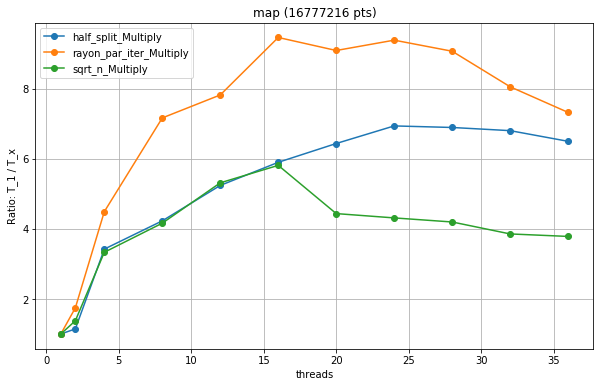

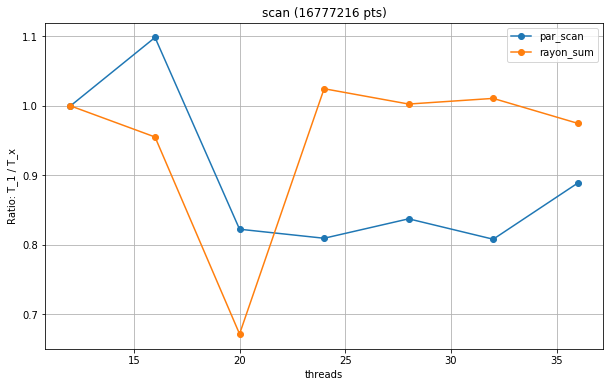

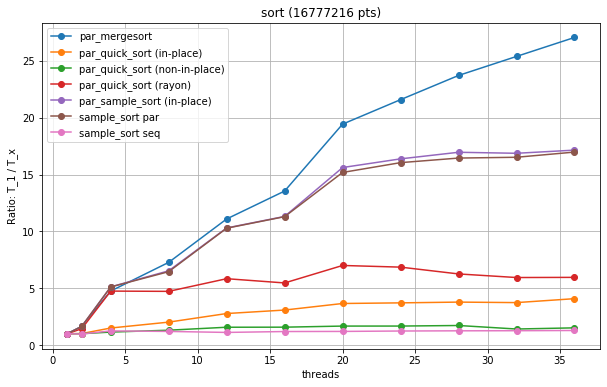

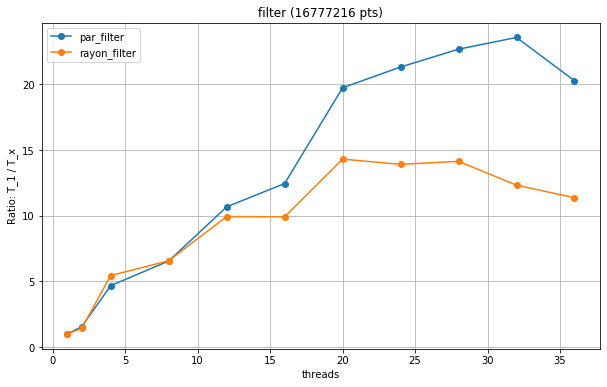

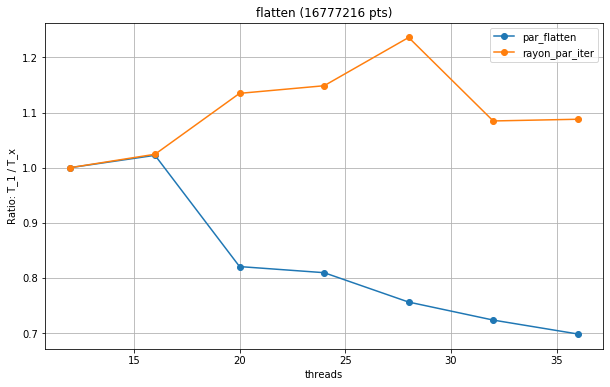

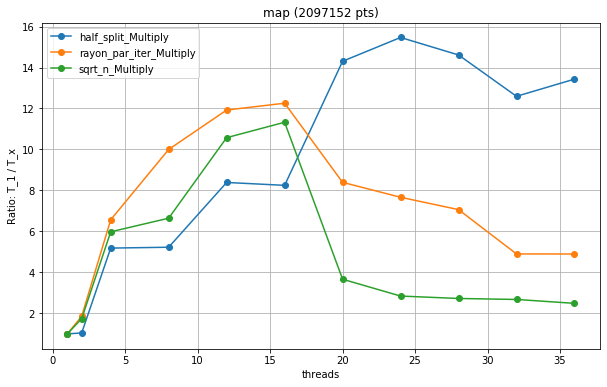

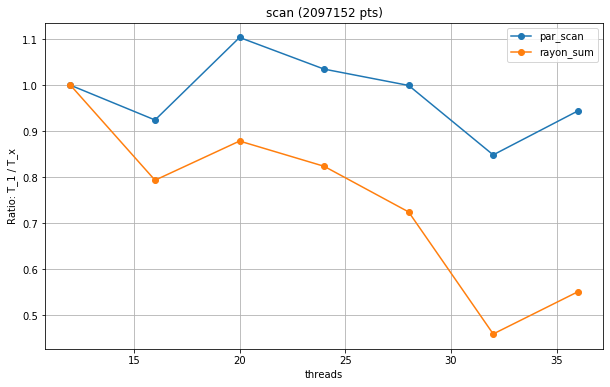

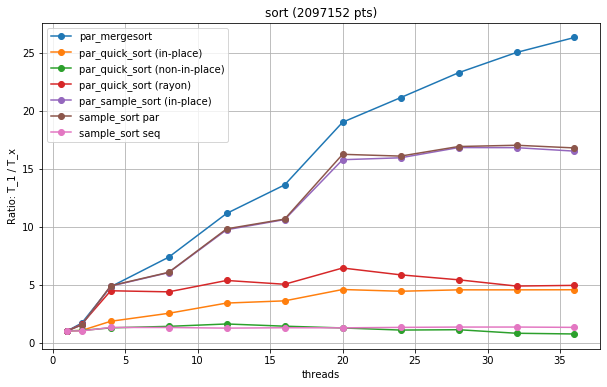

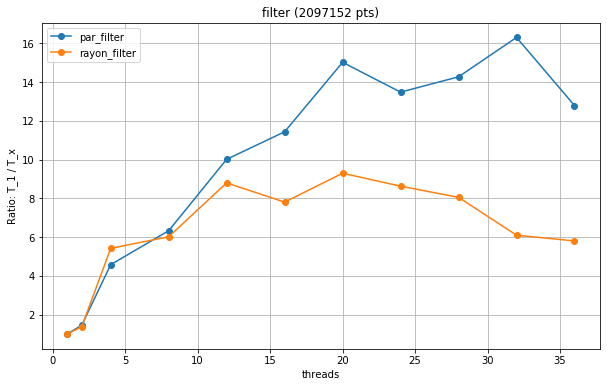

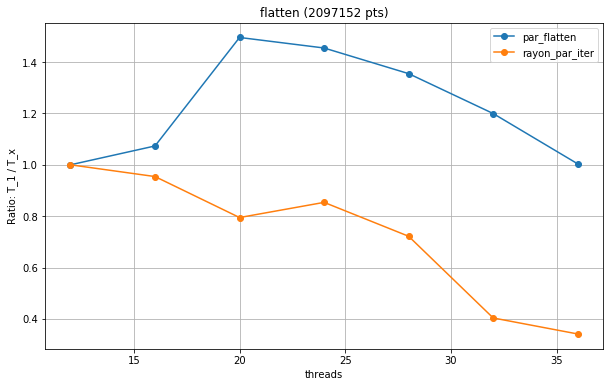

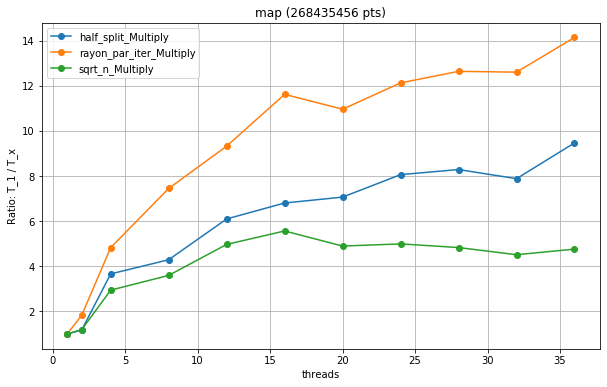

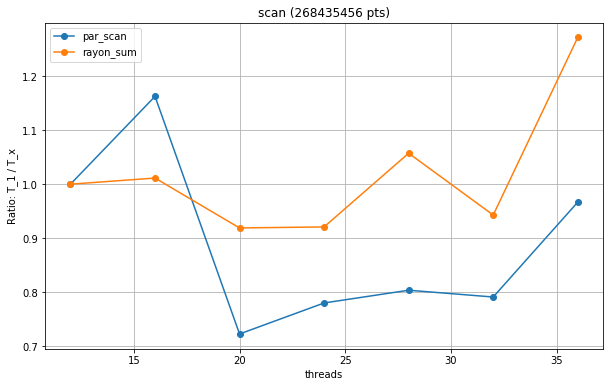

In [ ]:
for size, size_d in result.items():
    for alg, alg_d in size_d.items():
        plt.figure(figsize=(10,6))
        plt.title(f"{alg} ({size} pts)")
        for ver, ver_d in alg_d.items():
            rr = result[size][alg][ver]
            plt.xlabel("threads")
            plt.ylabel("Ratio: T_1 / T_x")
            plt.plot(rr['x'], rr['y'], marker='o', label=ver)
            plt.grid(True)
        plt.legend()
        plt.show()

In [7]:
rr = result[1048576]['merge_sort']['par_mergesort']
plt.title("Merge Sort (1048576)")
plt.xlabel("threads")
plt.ylabel("y: T_0/T_x")
plt.scatter(rr['x'], rr['y'], marker='o')
plt.grid(True)

KeyError: 'merge_sort'

In [89]:
pd.read_csv("DEBS2012-cleaned-v3.txt.small", header=None, delimiter=r"\s+")

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,2012-02-22,16:46:28.967032,2556001,13056,14406,8119,71,193,150,0,...,0,0,0,0,0,0,0,0,0,0
1,2012-02-22,16:46:28.977028,2556002,13054,14405,8119,69,192,151,0,...,0,0,0,0,0,0,0,0,0,0
2,2012-02-22,16:46:28.987021,2556003,13049,14404,8119,70,194,152,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-02-22,16:46:28.997043,2556004,13051,14401,8118,71,193,152,0,...,0,0,0,0,0,0,0,0,0,0
4,2012-02-22,16:46:29.007026,2556005,13049,14397,8116,69,191,156,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2012-02-22,16:46:31.917087,2556296,13045,14373,8126,64,189,151,0,...,0,0,0,0,0,0,0,0,0,0
296,2012-02-22,16:46:31.927085,2556297,13045,14370,8128,64,192,154,0,...,0,0,0,0,0,0,0,0,0,0
297,2012-02-22,16:46:31.937081,2556298,13043,14368,8128,64,190,154,0,...,0,0,0,0,0,0,0,0,0,0
298,2012-02-22,16:46:31.947123,2556299,13039,14367,8127,62,191,154,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
import math
bb = 4.98e8
n=134217728
x = math.log(n,2)
# print(x)
chars = 522611234
chars/bb

1.0494201485943775